In [1]:
!python --version

Python 3.8.19


# RIR Deconvolution and Acoustic Parameters Estiation (EDT - RT60)

The recorded sound in unity platform for a certian scene is deconvolved to get the room acoustic propertits in room impulse response (RIR). Early decay time (EDT) and reverberation time (RT60) are calculated.

In [2]:
!python -m ipykernel install --user --name RIR_env --display-name "Python (RIR_env)"


Installed kernelspec RIR_env in C:\Users\kproject\AppData\Roaming\jupyter\kernels\rir_env


In [3]:
#%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
#%pip install scipy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
#%pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
#%pip install audiolazy


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for audiolazy from https://files.pythonhosted.org/packages/65/97/0b9528016ce0d4d11380d9864b6fe3b3f7d8b358a841e3489fa84fd18792/audiolazy-0.6-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/45.1 kB ? eta -:--:--
     ---------------------------------------- 45.1/45.1 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/121.3 kB ? eta -:--:--
   ---------------------------------------- 121.3/121.3 kB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from scipy.io import wavfile
import os
from scipy.io.wavfile import write as wavwrite
import numpy as np
from scipy import signal
from scipy.signal import fftconvolve
#import deconvolotion3 as deconvolution
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
#from RIR_Segmentation import Segmentation
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.signal import resample


In [9]:
import numpy as np
from scipy.io.wavfile import write as wavwrite
import scipy.signal as signal
from scipy.io.wavfile import read
from scipy.signal import resample

def generate_exponential_sine_sweep(fs=48000, amplitude=0.5, duration=10, silenceAtStart=1, silenceAtEnd=1, sweeprange=[20, 20000], bit_depth=16):
    """
    Generate an exponential sine sweep and its inverse filter, and save them as WAV files with the specified bit depth.
    
    Parameters:
    - fs: Sampling rate (Hz)
    - amplitude: Amplitude of the sine sweep
    - duration: Duration of the sine sweep (seconds)
    - silenceAtStart: Silence duration at the start (seconds)
    - silenceAtEnd: Silence duration at the end (seconds)
    - sweeprange: Start and end frequencies of the sweep (Hz)
    - bit_depth: Bit depth of the output WAV files (16, 24, or 32)
    """
    # Define the frequency range for the sweep
    f1 = max(sweeprange[0], 1)  # start of sweep in Hz
    f2 = sweeprange[1] if sweeprange[1] != 0 else int(fs / 2)  # end of sweep in Hz
    
    w1 = 2 * np.pi * f1 / fs  # start of sweep in rad/sample
    w2 = 2 * np.pi * f2 / fs  # end of sweep in rad/sample
    
    numSamples = duration * fs
    taxis = np.arange(0, numSamples) / numSamples

    # Generate the exponential sine sweep
    lw = np.log(w2 / w1)
    sinsweep = amplitude * np.sin(w1 * numSamples / lw * (np.exp(taxis * lw) - 1))
    
    # Find the last zero crossing to avoid the need for fadeout
    k = np.flipud(sinsweep)
    error = 1
    counter = 0
    max_iterations = numSamples  # to avoid infinite loop

    while error > 0.001 and counter < max_iterations:
        error = np.abs(k[counter])
        counter += 1

    k = k[counter:]
    sinsweep_hat = np.flipud(k)
    sinsweep = np.zeros(shape=(numSamples,))
    sinsweep[:sinsweep_hat.shape[0]] = sinsweep_hat

    # Compute the inverse filter
    envelope = (w2 / w1) ** (-taxis)
    invfilter = np.flipud(sinsweep) * envelope
    scaling = np.pi * numSamples * (w1 / w2 - 1) / (2 * (w2 - w1) * np.log(w1 / w2)) * (w2 - w1) / np.pi
    invfilter = invfilter / amplitude ** 2 / scaling

    # Apply a Tukey window to taper the sine sweep
    taperStart = signal.tukey(numSamples, 0.1)  # Adjust alpha parameter for tapering
    sinsweep *= taperStart

    # Add silence at the start and end
    zerostart = np.zeros(shape=(silenceAtStart * fs,))
    zeroend = np.zeros(shape=(silenceAtEnd * fs,))
    sinsweep = np.concatenate((zerostart, sinsweep, zeroend))

    # Normalize and convert to the specified bit depth
    if bit_depth == 16:
        sinsweep = np.int16(sinsweep / np.max(np.abs(sinsweep)) * 32767)
        invfilter = np.int16(invfilter / np.max(np.abs(invfilter)) * 32767)
        wavwrite('sine_sweep_16bit.wav', fs, sinsweep)
        wavwrite('inverse_filter_16bit.wav', fs, invfilter)

        import os
        # Define the relative path, go up twice, and then to the sounds folder
        relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')
        # Create the full paths for the files
        sine_sweep_path = os.path.join(relative_path, 'sine_sweep_16bit.wav')
        inverse_filter_path = os.path.join(relative_path, 'inverse_filter_16bit.wav')
        # Write the files
        wavwrite(sine_sweep_path, fs, sinsweep)
        wavwrite(inverse_filter_path, fs, invfilter)

    elif bit_depth == 24:
        sinsweep = np.int32(sinsweep / np.max(np.abs(sinsweep)) * 8388607)
        invfilter = np.int32(invfilter / np.max(np.abs(invfilter)) * 8388607)
        wavfile.write('sine_sweep_24bit.wav', sinsweep, fs, subtype='PCM_24')
        wavfile.write('inverse_filter_24bit.wav', invfilter, fs, subtype='PCM_24')
    elif bit_depth == 32:
        sinsweep = sinsweep.astype(np.float32)
        invfilter = invfilter.astype(np.float32)
        wavwrite('sine_sweep_32bit.wav', fs, sinsweep)
        wavwrite('inverse_filter_32bit.wav', fs, invfilter)
    else:
        raise ValueError("Unsupported bit depth. Choose 16, 24, or 32.")

    print(f'Sine sweep and inverse filter generated and saved as {bit_depth}-bit WAV files.')
    return sinsweep, invfilter

# Run the function to generate the sine sweep and its inverse
generate_exponential_sine_sweep(bit_depth=16)  # Change bit_depth to 16, 24, or 32 as needed


Sine sweep and inverse filter generated and saved as 16-bit WAV files.


C:\Users\ChronoHax\AppData\Local\Temp\ipykernel_20492\3638851347.py:56: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  taperStart = signal.tukey(numSamples, 0.1)  # Adjust alpha parameter for tapering


(array([0, 0, 0, ..., 0, 0, 0], dtype=int16),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int16))

In [10]:

def deconvolve(recorded_sweep_path, inverse_filter_path, output_path):
    """
    Perform deconvolution to generate a room impulse response from a recorded sweep.
    
    Parameters:
    - recorded_sweep_path: Path to the recorded sweep audio file (WAV)
    - inverse_filter_path: Path to the inverse filter audio file (WAV)
    - output_path: Path to save the room impulse response (WAV)
    """
    # Load the recorded sweep and the inverse filter
    fs, recorded_sweep = wavfile.read(recorded_sweep_path)
    fs_inv, inverse_filter = wavfile.read(inverse_filter_path)
    
    
    # Perform deconvolution (convolution with the inverse filter)
    rir = signal.fftconvolve(recorded_sweep, inverse_filter, mode='full')
    
    # Normalize the impulse response
    rir = rir / np.max(np.abs(rir))
    
    # Save the room impulse response as a WAV file
    wavfile.write(output_path, fs, rir)
    
    print(f'Room impulse response generated and saved as {output_path}')
    return rir, fs

#### Read the recorded file
f, rec = wavfile.read('./KT_Unity_bf.wav')
rec = np.array(rec)
print('fs_recorded', f)
# Truncate one channel for deconvolution
rec_ch1 = rec[:, 1]
print('record', rec.shape)
print('record_ch1', rec_ch1.shape)
#wavwrite('MR_Unity_ch1.wav', f, rec_ch1.astype(np.float32))
wavwrite('KT_Unity_ch1_bf.wav', f, rec_ch1)

import os

# Define the relative path (same as before)
relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')

# Define paths for input and output files
recorded_sweep_path = 'KT_Unity_ch1_bf.wav'  # Assuming this is in the current directory
inverse_filter_path = 'inverse_filter_16bit.wav'  # Assuming this is in the current directory
output_path = os.path.join(relative_path, 'RIR_KT_Unity_bf.wav')

# Generate room impulse response
rir, fs = deconvolve(recorded_sweep_path, inverse_filter_path, output_path)

# Write the RIR to the specified path
wavwrite(output_path, fs, rir)

fs_recorded 48000
record (1200000, 2)
record_ch1 (1200000,)
Room impulse response generated and saved as ..\..\Atiyeh-RIR-evaluation-Matlab\sounds\KT_GDP\RIR_KT_Unity_bf.wav


In [31]:
################################################# Gun shot RIR ###################################################################
import os
from scipy.io import wavfile

# Define the relative path (same as before)
relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')

# Gun shot RIR
# Read the recorded file
input_file = 'RIR_KT_gun_Unity_dual_v2.wav'
f, rec = wavfile.read(input_file)
rec = np.array(rec)
print('fs_recorded', f)

# Truncate one channel for deconvolution
rec_ch1 = rec[:, 1]
print('record', rec.shape)
print('record_ch1', rec_ch1.shape)

# Define output paths
local_output = 'RIR_KT_gun_Unity_ch1_v2.wav'
relative_output = os.path.join(relative_path, 'RIR_KT_gun_Unity_ch1_v2.wav')

# Write the single channel audio to local and relative paths
wavfile.write(local_output, f, rec_ch1)
wavfile.write(relative_output, f, rec_ch1)  # Note: using rec_ch1 instead of rir

print(f"Files saved locally as {local_output} and in relative path as {relative_output}")

fs_recorded 44100
record (1317932, 2)
record_ch1 (1317932,)
Files saved locally as RIR_KT_gun_Unity_ch1_v2.wav and in relative path as ..\..\Atiyeh-RIR-evaluation-Matlab\sounds\KT_GDP\RIR_KT_gun_Unity_ch1_v2.wav


# Improved sine sweep signal and deconvolve by Muhammad

In [4]:
import numpy as np
from scipy.signal import chirp, tukey

def generate_improved_sine_sweep_v3(fs=48000, duration=20, f0=10, f1=22000, method='logarithmic', 
                                    silence_start=1.0, silence_end=1.0, taper=0.1, amplitude=0.9):
    """
    Generate an improved sine sweep signal for room impulse response measurement.
    
    Parameters:
    - fs: Sampling frequency (Hz)
    - duration: Sweep duration (seconds)
    - f0: Start frequency (Hz)
    - f1: End frequency (Hz)
    - method: 'logarithmic' or 'linear' sweep
    - silence_start: Duration of silence at the start (seconds)
    - silence_end: Duration of silence at the end (seconds)
    - taper: Fraction of signal duration to taper at both ends
    - amplitude: Peak amplitude of the sweep (0 to 1)
    
    Returns:
    - sweep: The generated sweep signal
    - inverse_filter: The inverse filter for deconvolution
    """
    
    # Generate time array
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    
    # Generate sweep using scipy's chirp function
    sweep = chirp(t, f0=f0, f1=f1, t1=duration, method=method)
    
    # Apply amplitude scaling
    sweep *= amplitude
    
    # Apply Tukey window for tapering
    window = tukey(len(sweep), alpha=taper)
    sweep *= window
    
    # Generate inverse filter
    if method == 'logarithmic':
        omega1, omega2 = 2 * np.pi * f0, 2 * np.pi * f1
        envelope = np.exp(-t * omega1 * (np.log(omega2/omega1) / duration))
        inverse_filter = sweep[::-1] * envelope
    else:
        inverse_filter = sweep[::-1]
    
    # Normalize inverse filter
    inverse_filter /= np.max(np.abs(inverse_filter))
    
    # Add silence at start and end
    silence_start_samples = int(silence_start * fs)
    silence_end_samples = int(silence_end * fs)
    sweep = np.pad(sweep, (silence_start_samples, silence_end_samples), 'constant')
    inverse_filter = np.pad(inverse_filter, (silence_start_samples, silence_end_samples), 'constant')
    
    return sweep, inverse_filter

# Usage
fs = 48000
sweep, inverse_filter = generate_improved_sine_sweep_v3(fs=fs, duration=20, f0=10, f1=22000, 
                                                        silence_start=1.0, silence_end=1.0)

# Convert to 16-bit PCM and save
sweep_int16 = np.int16(sweep * 32767)
inverse_int16 = np.int16(inverse_filter * 32767)
wavfile.write('improved_sine_sweep_v3.wav', fs, sweep_int16)
wavfile.write('improved_inverse_filter_v3.wav', fs, inverse_filter)

print("Improved sine sweep and inverse filter (v3) generated and saved.")

Improved sine sweep and inverse filter (v3) generated and saved.


In [5]:
def improved_deconvolve(recorded_sweep, inverse_filter, fs, plot=False):
    rir = fftconvolve(recorded_sweep, inverse_filter, mode='full')
    rir = rir[len(inverse_filter)-1:]
    
    window_length = min(len(rir), int(fs * 2))
    window = np.hanning(window_length)
    rir[:window_length] *= window
    
    rir /= np.max(np.abs(rir))
    
    if plot:
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        time_axis = np.arange(len(rir)) / fs
        plt.plot(time_axis, rir)
        plt.title('Room Impulse Response')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        plt.subplot(2, 1, 2)
        freq_response = np.abs(np.fft.rfft(rir))
        freq_axis = np.fft.rfftfreq(len(rir), d=1/fs)
        plt.semilogx(freq_axis, 20 * np.log10(freq_response))
        plt.title('Frequency Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.xlim(20, fs/2)
        plt.ylim(-60, 0)
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return rir

fs_recorded 48000
record (2160000, 2)
record_ch1 (2160000,)


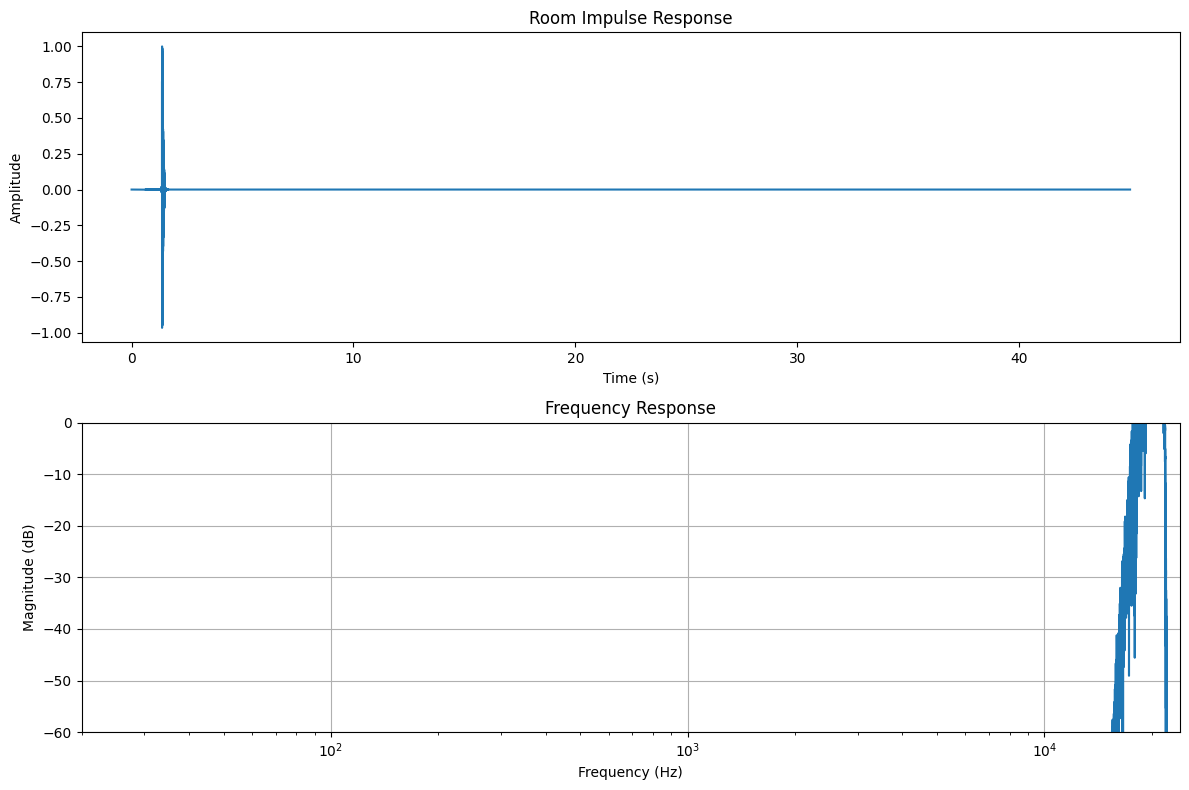

Room Impulse Response generated and saved as ..\..\Atiyeh-RIR-evaluation-Matlab\sounds\KT_GDP\RIR_KT_Unity_bf.wav
RIR plot saved as ..\..\Atiyeh-RIR-evaluation-Matlab\sounds\KT_GDP\RIR_KT_Unity_bf_plot.png


In [9]:
import numpy as np
from scipy.io import wavfile
import os

# Define the relative path
relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')

# Read the recorded file
recorded_sweep_path = 'KT_Unity_bf.wav'
f, rec = wavfile.read(recorded_sweep_path)
rec = np.array(rec)
print('fs_recorded', f)

# Truncate one channel for deconvolution
rec_ch1 = rec[:, 1]
print('record', rec.shape)
print('record_ch1', rec_ch1.shape)

# Save the single-channel recorded sweep
single_channel_path = 'KT_Unity_ch1_bf.wav'
wavfile.write(single_channel_path, f, rec_ch1)

# Define paths for input and output files
inverse_filter_path = 'improved_inverse_filter_v3.wav'  # Updated name
output_path = os.path.join(relative_path, 'RIR_KT_Unity_bf.wav')

# Read the new inverse filter
_, inverse_filter = wavfile.read(inverse_filter_path)
inverse_filter = inverse_filter.astype(float) / 32768.0

# Generate room impulse response using the improved deconvolve function
rir = improved_deconvolve(rec_ch1, inverse_filter, f, plot=True)

# Save the RIR
wavfile.write(output_path, f, np.int16(rir * 32767))

print(f"Room Impulse Response generated and saved as {output_path}")
print(f"RIR plot saved as {output_path.replace('.wav', '_plot.png')}")

# Return rir and fs for further processing
fs = f

In [7]:
def calculate_rt60(rir, fs, plot=False):
    rir_db = 10 * np.log10(np.abs(rir)**2)
    rir_db -= np.max(rir_db)
    
    # Calculate Schroeder integral
    schroeder = 10 * np.log10(np.flipud(np.cumsum(np.flipud(10**(rir_db/10)))))
    
    # Find the index where the decay reaches -5 dB and -35 dB
    idx_5db = np.where(schroeder <= -5)[0][0]
    idx_35db = np.where(schroeder <= -35)[0][0]
    
    # Calculate RT60
    t_5db = idx_5db / fs
    t_35db = idx_35db / fs
    rt60 = 2 * (t_35db - t_5db)
    
    if plot:
        plt.figure(figsize=(10, 6))
        time_axis = np.arange(len(rir)) / fs
        plt.plot(time_axis, schroeder)
        plt.axhline(y=-5, color='r', linestyle='--')
        plt.axhline(y=-35, color='r', linestyle='--')
        plt.axvline(x=t_5db, color='g', linestyle='--')
        plt.axvline(x=t_35db, color='g', linestyle='--')
        plt.title('Schroeder Decay Curve')
        plt.xlabel('Time (s)')
        plt.ylabel('Level (dB)')
        plt.grid(True)
        plt.show()
    
    return rt60

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [8]:
# Calculate and plot RT60
rt60 = calculate_rt60(rir, fs_rec, plot=True)
print(f"RT60: {rt60:.2f} seconds")

# Calculate RT60 for different frequency bands
frequency_bands = [(125, 250), (250, 500), (500, 1000), (1000, 2000), (2000, 4000), (4000, 8000)]

for low, high in frequency_bands:
    filtered_rir = bandpass_filter(rir, low, high, fs_rec)
    rt60_band = calculate_rt60(filtered_rir, fs_rec)
    print(f"RT60 ({low}-{high} Hz): {rt60_band:.2f} seconds")


NameError: name 'fs_rec' is not defined